In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
import numpy as np
from datetime import datetime
from src import utils, plotting, scoring
from sklearn.metrics import f1_score

In [17]:
monitor = scoring.PerformanceTracker()

Dados

In [18]:
# Parâmetros
n_samples = 100000 
n_features = 20  
n_informative = 2   # Número de características informativas
n_redundant = 2    # Número de características redundantes
weights = [0.2, 0.8]  # Desbalanceamento

# Gerar os dados
X, y = make_classification(n_samples=n_samples, 
                           n_features=n_features, 
                           n_informative=n_informative, 
                           n_redundant=n_redundant, 
                           #weights=weights,
                           flip_y=0.05, 
                           random_state=42,
                           )

In [19]:
# Criar DataFrame
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
df['target'] = y
df['datetime'] = utils.generate_random_dates_within_interval(datetime(2021, 1, 1), 4, n_samples)
df_train = df[df["datetime"] < '2024']
df_reference = df[(df["datetime"] >= '2024-01-01') & (df["datetime"] < '2024-07-01')].copy()
df_test = df[(df["datetime"] >= '2024-07-01')].copy()

In [20]:
X_train = df_train[df_train.columns[:-2]]
y_train = df_train["target"]

In [21]:
rf = RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1, class_weight="balanced")
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, oob_score=True,
                       random_state=42)

df_test

In [22]:
y_prob = rf.predict_proba(df_test[df_test.columns[:-2]])
y_pred = rf.predict(df_test[df_test.columns[:-2]])
y_prob = y_prob[np.arange(len(df_test)), y_pred]
df_test["y_prob"] = y_prob
df_test["prediction"] = y_pred

df_reference

In [23]:
y_prob = rf.predict_proba(df_reference[df_reference.columns[:-2]])
y_pred = rf.predict(df_reference[df_reference.columns[:-2]])
y_prob = y_prob[np.arange(len(y_prob)), y_pred]
df_reference["y_prob"] = y_prob
df_reference["prediction"] = y_pred

In [24]:
monitor.fit(df_reference, "W", "target", "prediction", f1_score)
result = monitor.metric_by_time_period(df_reference, 'W', 'target', 'prediction', f1_score)

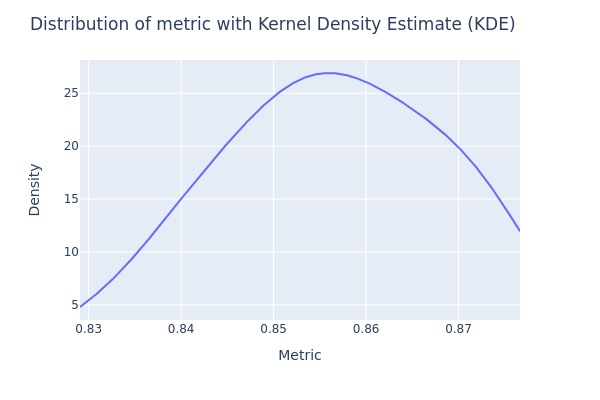

In [25]:
plotting.kde(result, 'metric', fig_type="png")


In [26]:
monitor.reference_metrics

{'ci_lower': 0.8489823744269228,
 'ci_upper': 0.8625485980063029,
 'mean': 0.856128632809579,
 'lower_threshold': 0.8189637750591849,
 'upper_threshold': 0.893293490559973}

In [27]:
reference_score = monitor.metric_by_time_period(df_reference, 'W', 'target', 'prediction')

# Reference

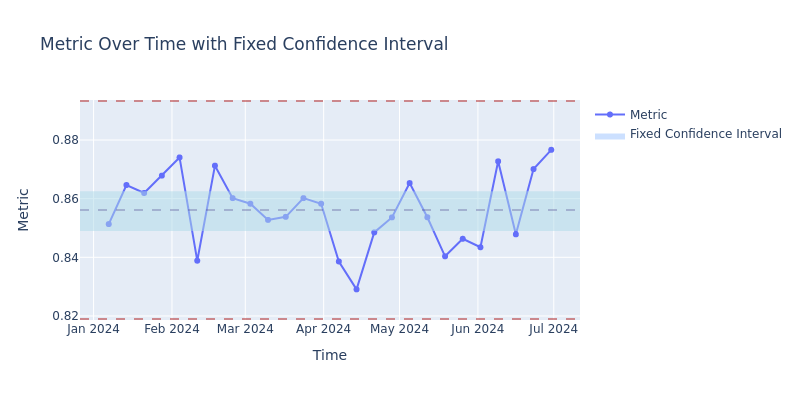

In [28]:
plotting.performance_by_time(monitor.reference_metrics, reference_score, fig_type="png")

# Analysis

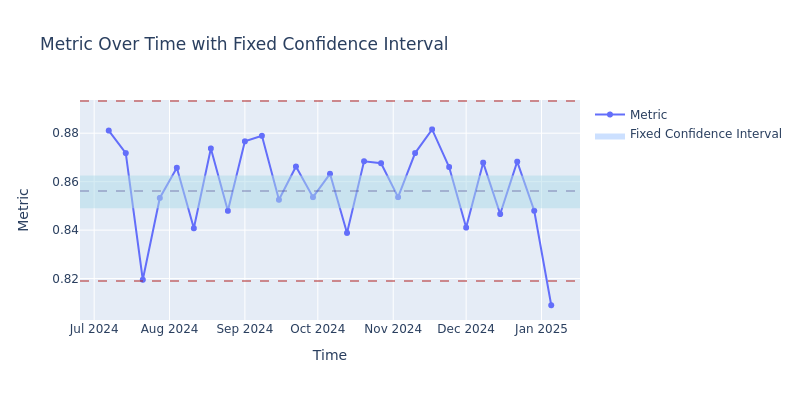

In [29]:
analysis_score = monitor.metric_by_time_period(df_test, 'W', 'target', 'prediction', f1_score)
plotting.performance_by_time(monitor.reference_metrics, analysis_score, fig_type="png")